## Selecting boundaries for spatial statistics

When considering spatial metrics, it's important to ensure that we consider the correct <i>boundary</i> when calculating statistcs. For most statistics in MuSpAn, we can pass in queries that describe a set of shapes to include for our analysis, `include_regions`, and a set to exclude, `exclude_regions`. MuSpAn will adjust the contribution of points close to these boundaries, ensuring that the spatial statistics are representative of the specified points within the specified regions.

Let's demonstrate this using the PanCK boundaries in the Macrophage-Hypoxia-ROI dataset.

MuSpAn domain loaded successfully. Domain summary:
Domain name: Example ROI from Pugh/Macklin H&N cancer hypoxia data
Number of objects: 1163
Collections: ['Macrophages', 'Pimo', 'PanCK', 'CAIX', 'Simplified boundaries']
Labels: [] 
Networks: [] 
Distance matrices: []


(<Figure size 2000x1600 with 2 Axes>, <Axes: >)

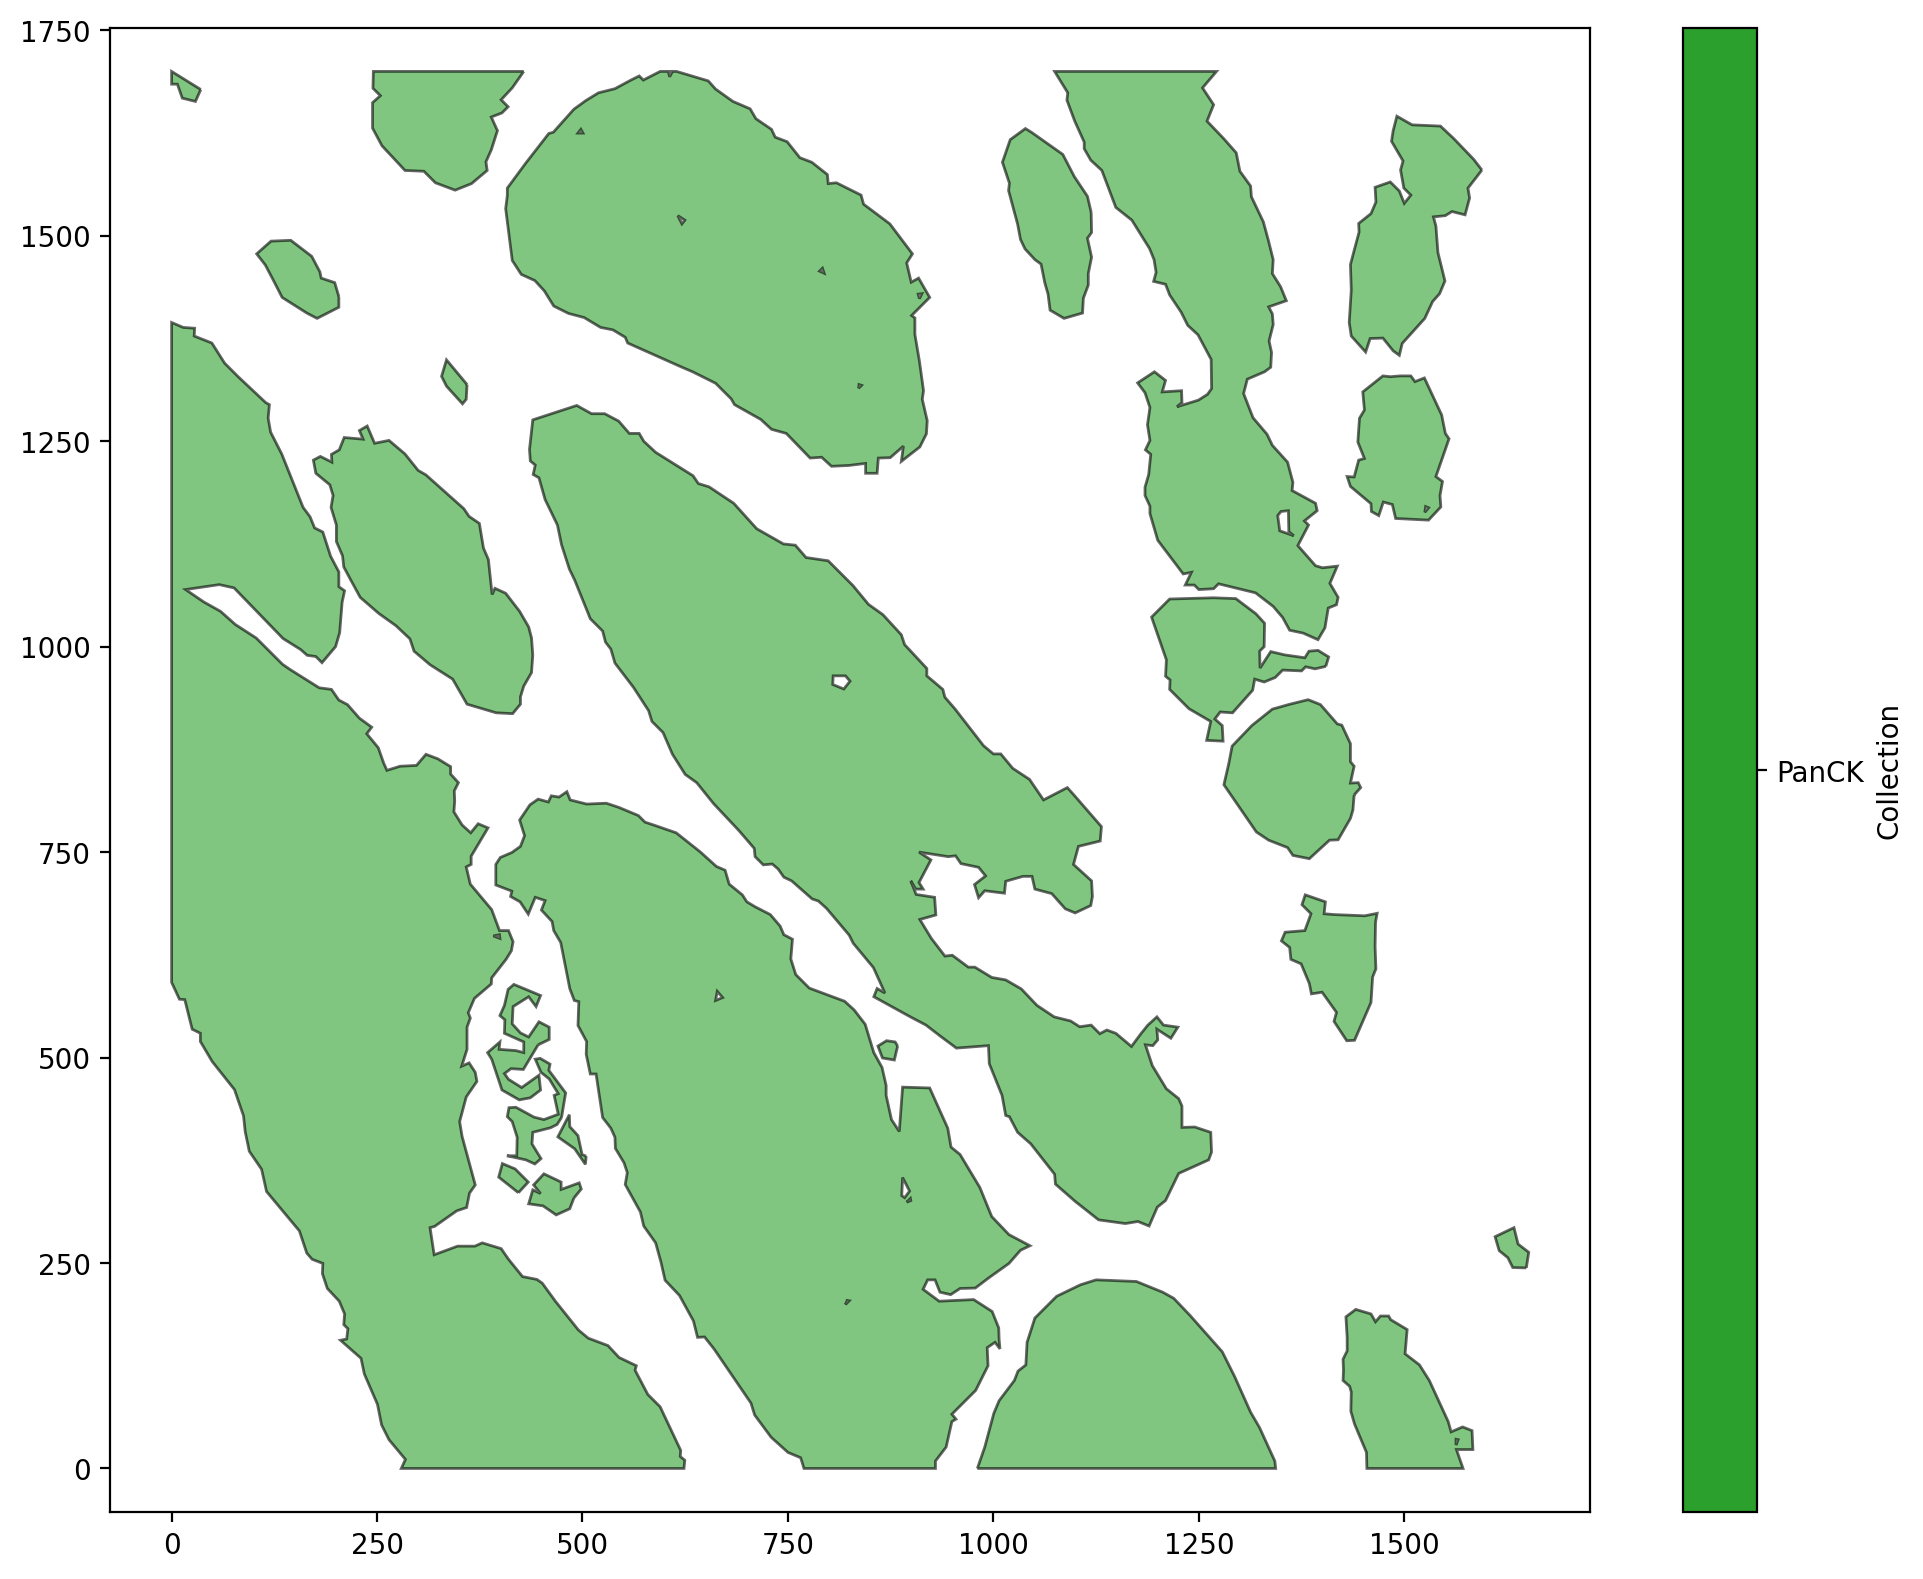

In [1]:
# Import necessary libraries
import numpy as np
import matplotlib.pyplot as plt
import muspan as ms

# Set the resolution for matplotlib figures
plt.rcParams['figure.dpi'] = 200

# Load the example domain dataset
domain = ms.datasets.load_example_domain('Macrophage-Hypoxia-ROI')

# Define a query to select the PanCK boundaries
query_PanCK = ms.query.query(domain, ('collection',), 'is', 'PanCK')

# Visualize the domain with the PanCK boundaries
ms.visualise.visualise(domain, objects_to_plot=query_PanCK)

We'll use some synthetic data within these boundaries to demonstrate how MuSpAn can be used to interrogate different boundaries. Let's choose 200 points with label 'A' across the ROI, completely at random, and keep track of whether they fall inside of outside of the PanCK.

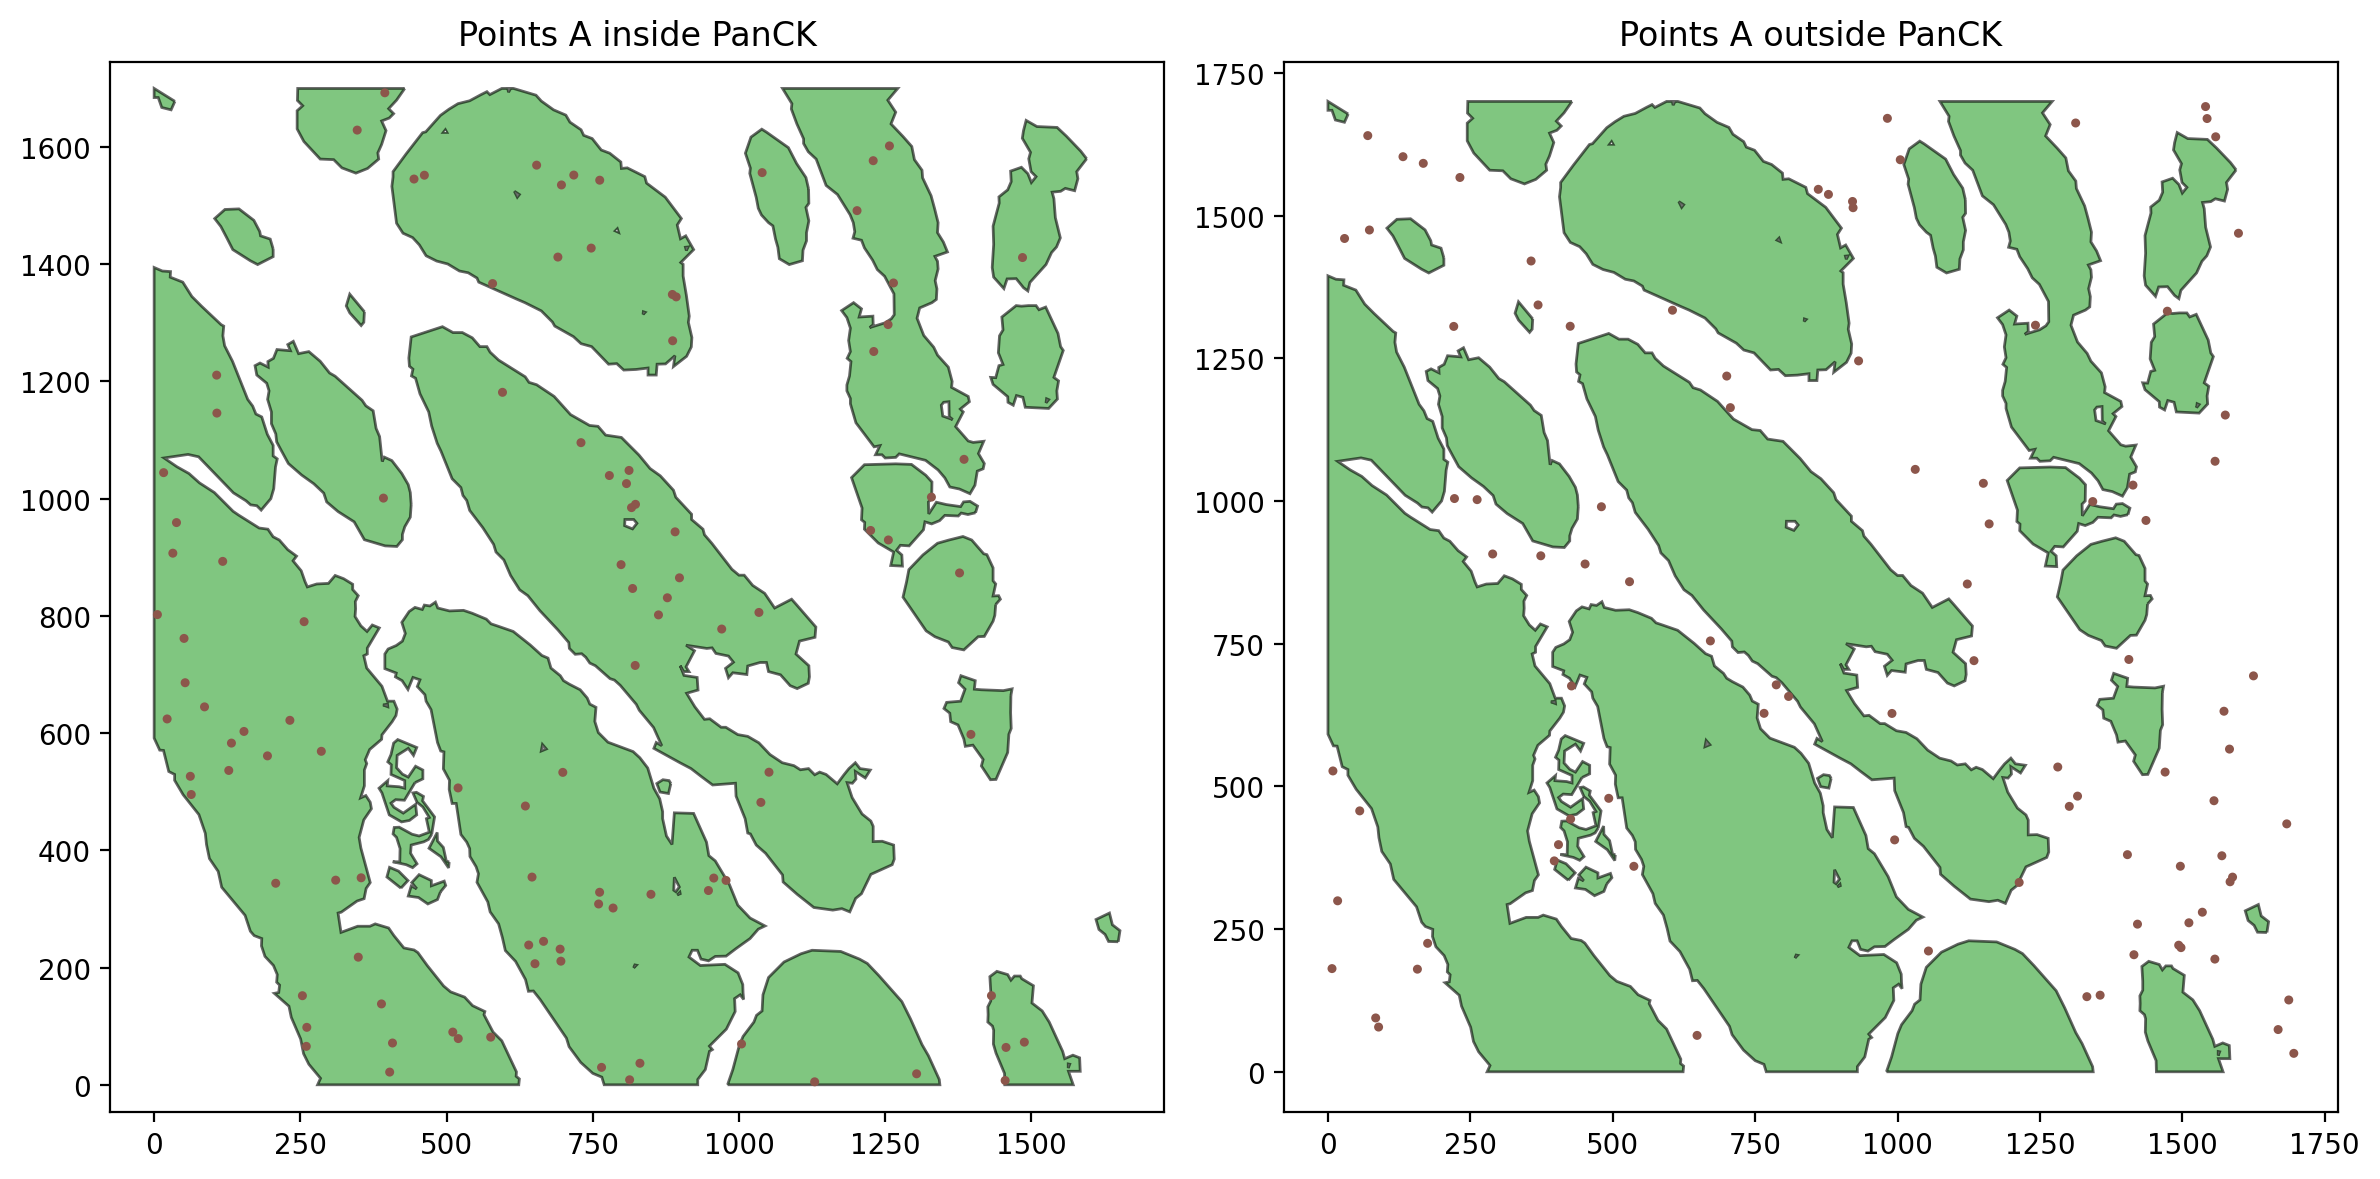

In [2]:
# Add 200 random points labeled 'A' across the ROI
points_A = np.random.rand(200, 2) * [1700, 1700]
IDs_A = domain.add_points(points_A, 'Synthetic data', return_IDs=True)
domain.add_labels('Celltype', ['A' for _ in range(200)], add_labels_to=IDs_A)

# Use a query to get all points 'A' inside and outside the PanCK boundaries
A_in_PanCK = ms.query.query(domain, ('contains', (IDs_A, query_PanCK)), 'is', True)
A_not_in_PanCK = ms.query.query(domain, ('contains', (IDs_A, query_PanCK)), 'is not', True)

# Visualize the points 'A' inside and outside the PanCK boundaries
fig, ax = plt.subplots(1, 2, figsize=(12, 6))

# Plot points 'A' inside the PanCK boundaries
ms.visualise.visualise(domain, objects_to_plot=query_PanCK, ax=ax[0], add_cbar=False)
ms.visualise.visualise(domain, objects_to_plot=A_in_PanCK, ax=ax[0], add_cbar=False, marker_size=5)
ax[0].set_title('Points A inside PanCK')

# Plot points 'A' outside the PanCK boundaries
ms.visualise.visualise(domain, objects_to_plot=query_PanCK, ax=ax[1], add_cbar=False)
ms.visualise.visualise(domain, objects_to_plot=A_not_in_PanCK, ax=ax[1], add_cbar=False, marker_size=5)
ax[1].set_title('Points A outside PanCK')

plt.tight_layout()
plt.show()

Now let's add a second population. For each point with label 'A' inside a PanCK boundary, we'll place 2 points with label 'B' nearby. Outside the PanCK, we'll place 'B' points completely independently from where the 'A' points are, using the same process as before.

(<Figure size 2000x1600 with 1 Axes>, <Axes: >)

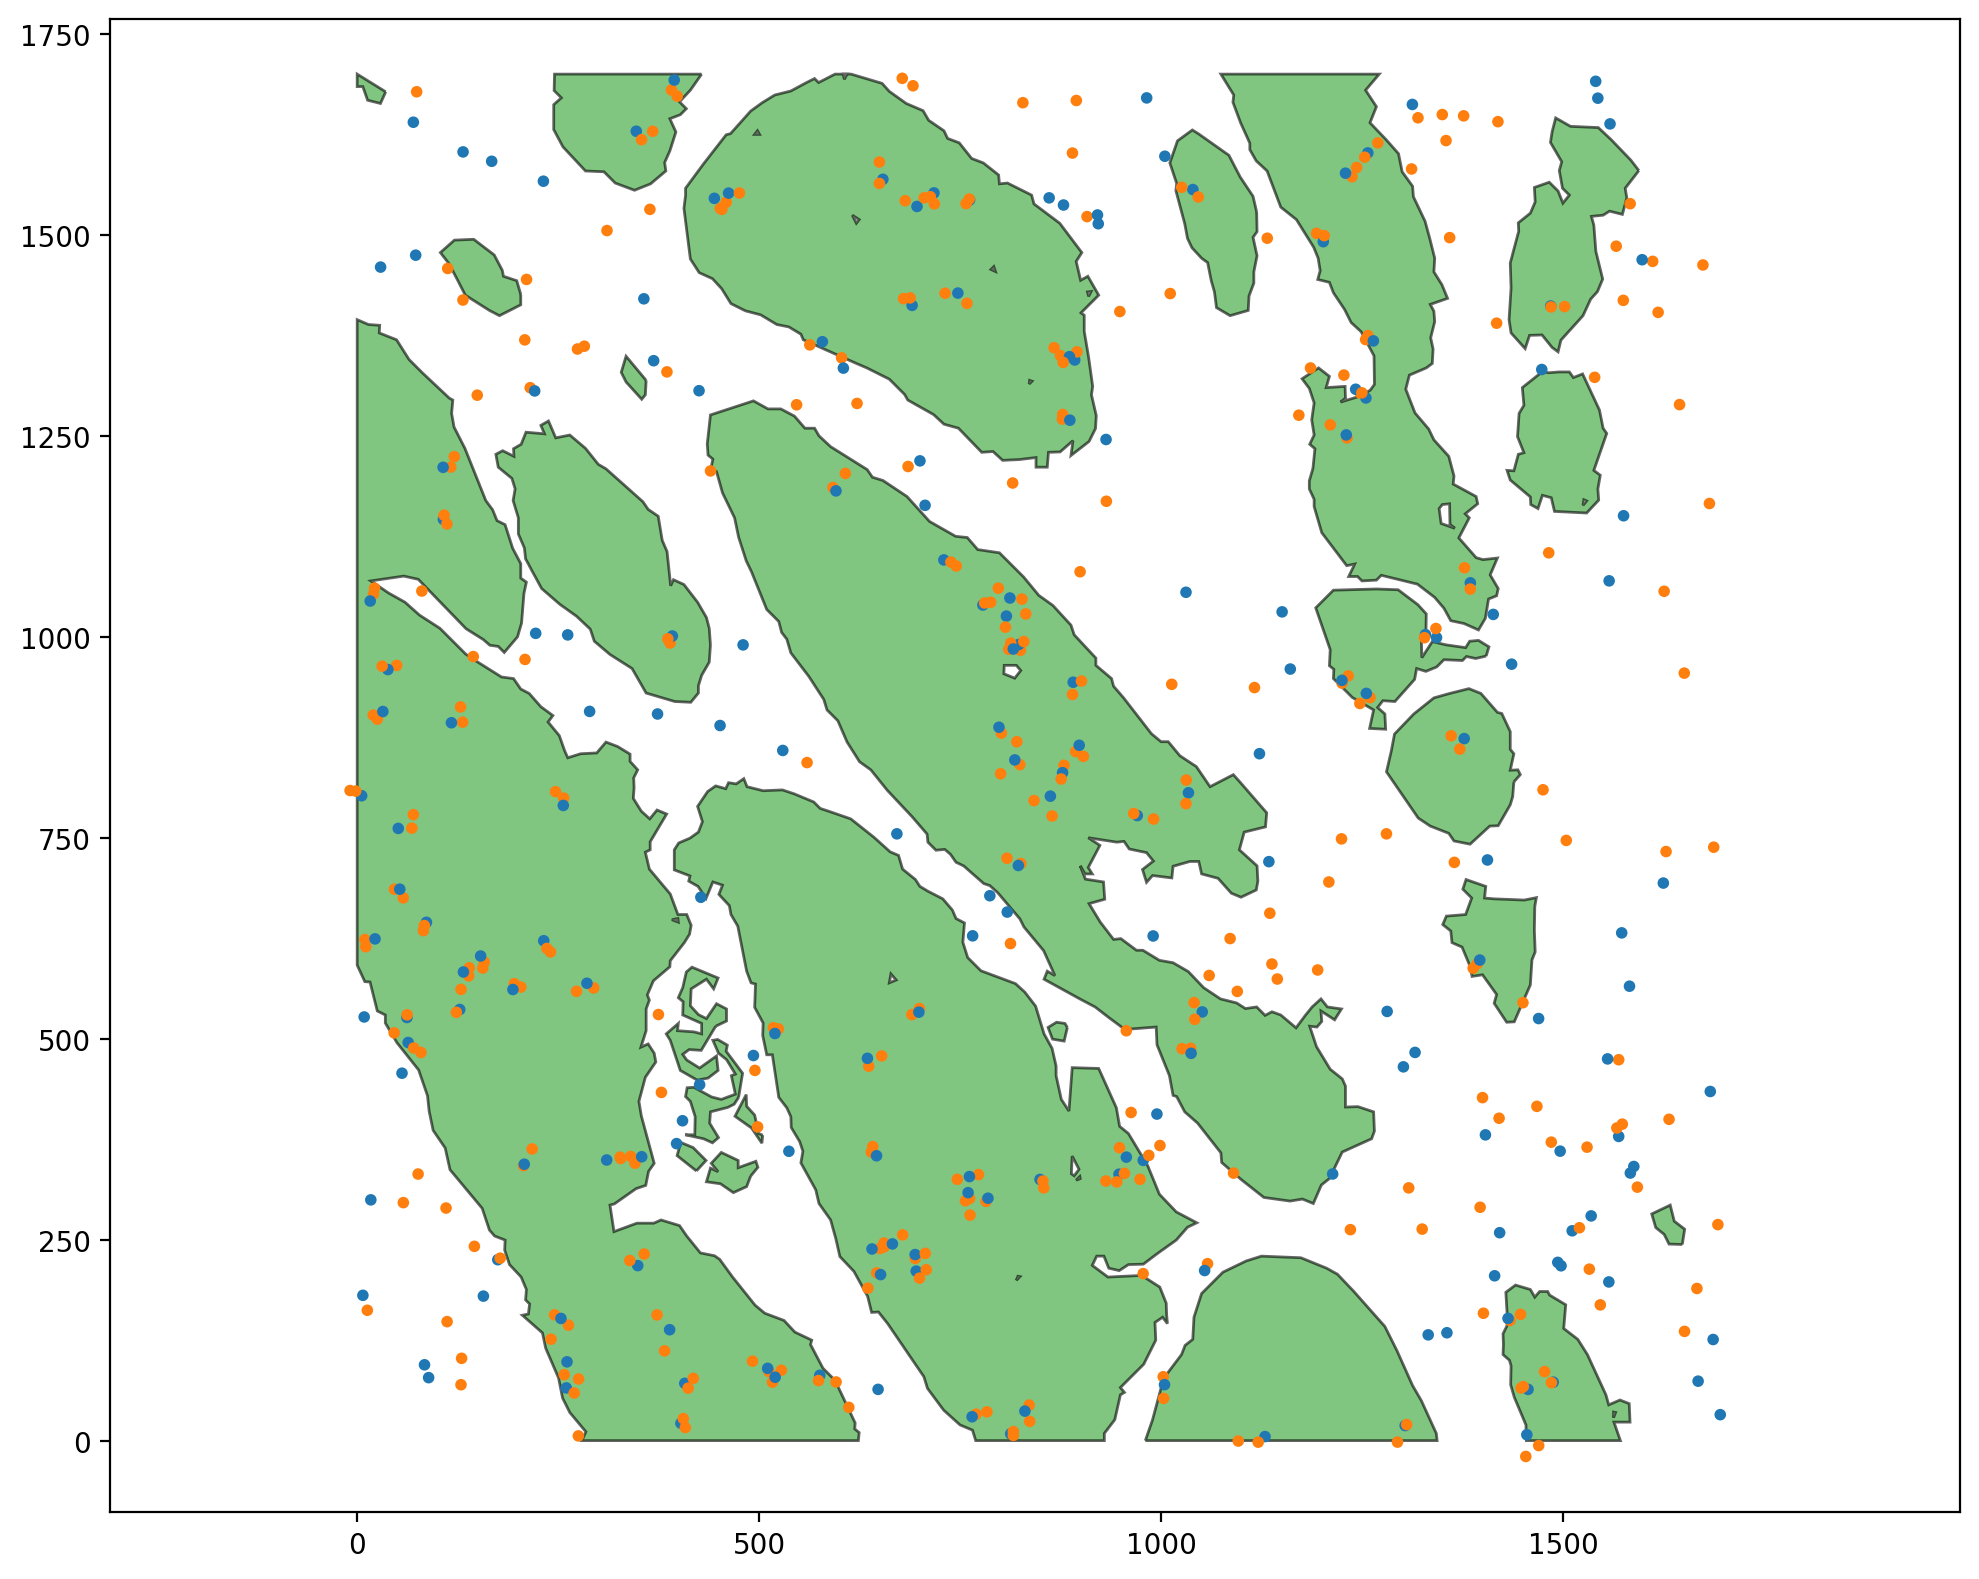

In [3]:
# Sample 200 random locations, and reject any which are inside the PanCK
locations = np.random.rand(200, 2) * [1700, 1700]

# Add the locations to the domain
IDs = domain.add_points(locations, 'Synthetic data', return_IDs=True)

# Query to find points inside and outside the PanCK boundaries
IDs_B_inside_PanCK = ms.query.query(domain, ('contains', (IDs, query_PanCK)), 'is', True)
IDs_B_outside_PanCK = ms.query.query(domain, ('contains', (IDs, query_PanCK)), 'is not', True)

# Delete the new objects which are inside the PanCK boundaries
domain.delete_objects(IDs_B_inside_PanCK)

# Label the remaining objects (those outside the PanCK) as type 'B' cells
n_outside = len(ms.query.interpret_query(IDs_B_outside_PanCK))
domain.add_labels('Celltype', ['B' for _ in range(n_outside)], add_labels_to=IDs_B_outside_PanCK)

# Now place more B points close to the A points INSIDE the PanCK
points_B = np.empty(shape=(0, 2))
for ID_a in ms.query.interpret_query(A_in_PanCK):
    # Get the object coordinates
    a_coords = domain.objects[ID_a].centroid
    for j in range(2):
        # Choose points nearby
        b_coords = a_coords + np.random.randn(1, 2) * 10
        points_B = np.vstack((points_B, b_coords))

# Add the new B points to the domain and label them
IDs_B = domain.add_points(points_B, 'Synthetic data', return_IDs=True)
domain.add_labels('Celltype', ['B' for _ in range(len(IDs_B))], add_labels_to=IDs_B)

# Visualize the domain with the PanCK boundaries and the synthetic data points
ms.visualise.visualise(domain, objects_to_plot=query_PanCK, add_cbar=False)
ms.visualise.visualise(domain, objects_to_plot=('collection', 'Synthetic data'), color_by='Celltype', ax=plt.gca(), add_cbar=False, marker_size=10)

Anyway, let's do a PCF from A to B.

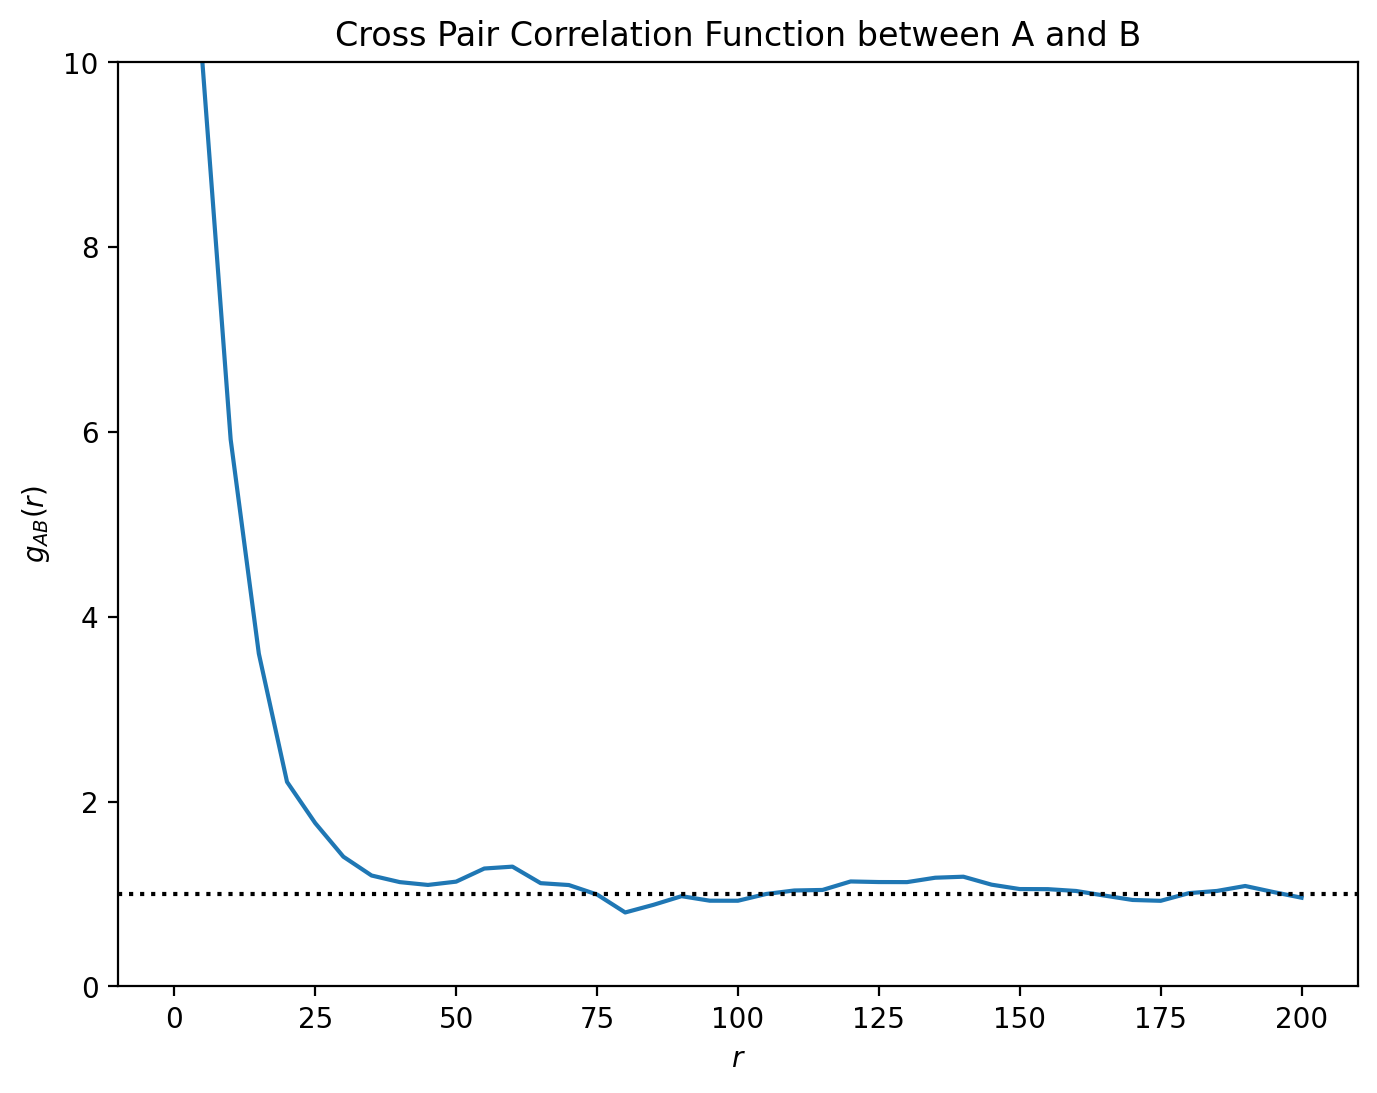

In [4]:
# Query to get all points labeled 'A' and 'B'
pop_A = ms.query.query(domain, ('label', 'Celltype'), 'is', 'A')
pop_B = ms.query.query(domain, ('label', 'Celltype'), 'is', 'B')

# Calculate the cross pair correlation function (PCF) between populations A and B
r, PCF = ms.spatial_statistics.cross_pair_correlation_function(domain, population_A=pop_A, population_B=pop_B, max_R=200, annulus_step=5, annulus_width=10)

# Plot the PCF
plt.figure(figsize=(8, 6))
plt.plot(r, PCF)
plt.gca().axhline(1, c='k', linestyle=':')
plt.ylim([0, 10])
plt.ylabel('$g_{AB}(r)$')
plt.xlabel('$r$')
plt.title('Cross Pair Correlation Function between A and B')
plt.show()

This PCF indicates short range clustering between our A and B type cells, up to distances of around 25 microns separation, with no spatial correlation at longer length scales. However, we can restrict the PCF analysis to distinct spatial regions using the `include_boundaries` and `exclude_boundaries` keywords. Let's recalculate the same PCF twice, first restricted to the stroma (excluding the PanCK) and secondly restricted to the tumour (including only the PanCK). Notice that calculations involving specified boundaries are slower than those without - in general, these will add additional scaling complexity to the algorithm with the number of distinct boundaries added, and the complexity of those boundaries.

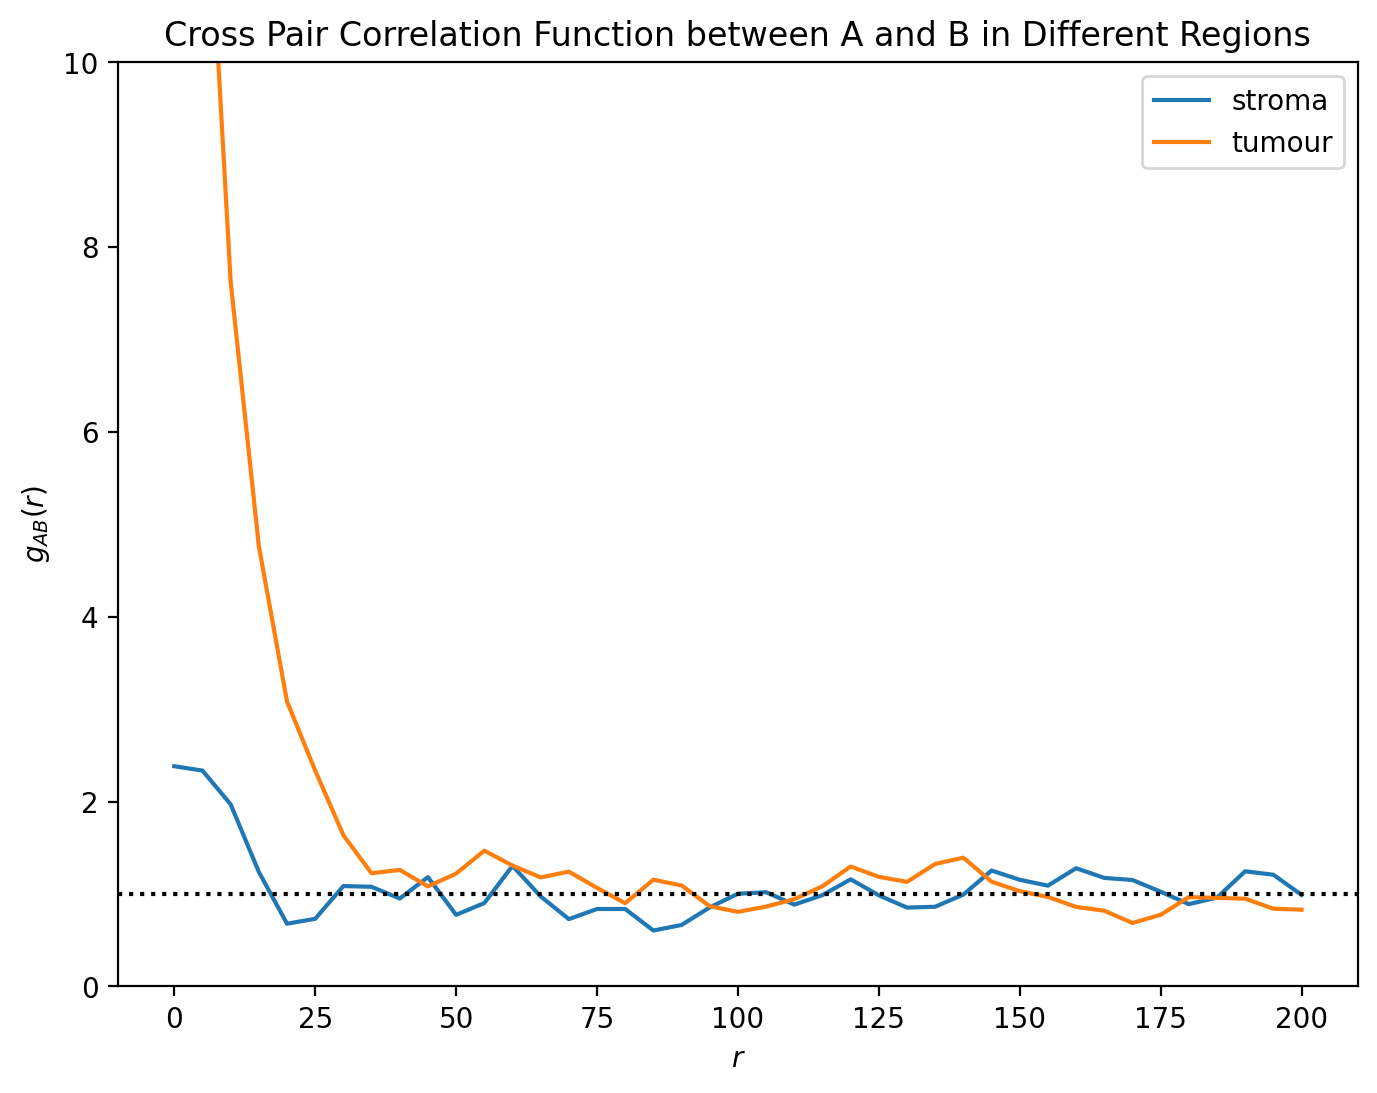

In [5]:
# Calculate the cross pair correlation function (PCF) between populations A and B
# excluding the PanCK boundaries (stroma) and including only the PanCK boundaries (tumour)
r_stroma, PCF_stroma = ms.spatial_statistics.cross_pair_correlation_function(
    domain, 
    population_A=pop_A, 
    population_B=pop_B, 
    exclude_boundaries=query_PanCK, 
    max_R=200, 
    annulus_step=5, 
    annulus_width=10
)
r_tumour, PCF_tumour = ms.spatial_statistics.cross_pair_correlation_function(
    domain,
    population_A=pop_A, 
    population_B=pop_B, 
    include_boundaries=query_PanCK, 
    max_R=200, 
    annulus_step=5, 
    annulus_width=10
)

# Plot the PCF for both stroma and tumour regions
plt.figure(figsize=(8, 6))
plt.plot(r_stroma, PCF_stroma, label='stroma')
plt.plot(r_tumour, PCF_tumour, label='tumour')
plt.gca().axhline(1, c='k', linestyle=':')
plt.ylim([0, 10])
plt.ylabel('$g_{AB}(r)$')
plt.xlabel('$r$')
plt.legend()
plt.title('Cross Pair Correlation Function between A and B in Different Regions')
plt.show()

Here, we can see the distinct spatial patterns - within the tumour, A and B cells are strongly colocalised, with the PCF much greater than 1 when $r < 25$. On the other hand, outside of the tumour this correlation vanishes, with the PCF close to 1 for all values of r.